# 作业：手写数字加法机

本文件是与集智AI学园出品的系列课程“火炬上的深度学习”配套的作业notebook。本作业要求学员构造一个卷积神经网，输入两张手写数字图片，输出这两个数字的和。

本文件提供了一个完成做的大框架，学员需要自行修改、添加代码，从而完成任务

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码


In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:

# 定义需要用到的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中

train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个

sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))

# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler2
                                           )

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

# MINST Adder

为了实现加法器，需要同时处理两个手写体数字图像，并对它进行相应的图像处理
因此，网络的架构为两个卷积神经网络，串联上两个全链接层

In [3]:
depth = [4, 8]
class MINSTAdder(nn.Module):
    def __init__(self):
        super(MINSTAdder, self).__init__()
#        #处理第一个图像处理用的卷积网络部件
        self.net1_conv1 = nn.Conv2d(1, 4, 5, padding = 2)
        self.net_pool = nn.MaxPool2d(2, 2)
        self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        
#        #处理第二个图像处理用的卷积网络部件
        self.net2_conv1 = nn.Conv2d(1, 4, 5, padding = 2)
        self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        
#        #后面的全连阶层
        self.fc1 = nn.Linear(2 * image_size // 4 * image_size // 4 * depth[1] , 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x, y, training = True):
#        #第一张图像的处理流程
        x = F.relu(self.net1_conv1(x))
        x = self.net_pool(x)
        x = F.relu(self.net1_conv2(x))
        x = self.net_pool(x)
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
#        #第二张图像的处理流程
        y = F.relu(self.net2_conv1(y))
        y = self.net_pool(y)
        y = F.relu(self.net2_conv2(y))
        y = self.net_pool(y)
        y = y.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
#        #将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
        z = torch.cat((x, y), 1)    #size = 1*20
        z = self.fc1(z) 
        z = F.relu(z)
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc2(z)
        return z

## 计算准确度的函数（有多少数字给出了严格的正确输出结果）
def rightness(y, target):
    out = torch.round(y).type(torch.LongTensor)
    out = out.eq(target).data.sum()
    out1 = y.size()[0]
    return(out, out1)

In [4]:
# 将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平方误差作为我们的损失函数
net = MINSTAdder()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)
results = {}

In [33]:
# 开始训练循环，本部分代码需要补齐
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    train_rights = []
#    # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        ((x1, y1), (x2, y2)) = data
        optimizer.zero_grad()
        net.train()
        outputs = net(Variable(x1), Variable(x2))
        labels = y1 + y2
        loss = criterion(outputs, Variable(labels.type(torch.FloatTensor)))
        #print(loss)
        losses.append(loss.data[0])
        #print(losses)
        loss.backward()
        optimizer.step()
        
        right = rightness(outputs.squeeze(), Variable(labels))
        #print(right)
        train_rights.append(right)
        
        
        
        if idx % 100 == 0:
#            #每间隔一定周期就打印一下训练集、校验集的准确率结果
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            #print(train_r)
            right_ratio = train_r[0]/train_r[1]
            #print("right_ratio=", right_ratio)
        
            net.eval()
            val_losses = []
            for data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = data
                output = net(Variable(x1), Variable(x2))
                label = y1 + y2
                loss = criterion(output, Variable(label.type(torch.FloatTensor)))
                val_losses.append(loss.data[0])
            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), 1-right_ratio])

第0周期，第(0/938)个撮，训练误差：1.97, 校验误差：3.02, 准确率：0.31
第0周期，第(100/938)个撮，训练误差：2.82, 校验误差：2.78, 准确率：0.26
第0周期，第(200/938)个撮，训练误差：2.78, 校验误差：2.75, 准确率：0.27
第0周期，第(300/938)个撮，训练误差：2.77, 校验误差：2.72, 准确率：0.27
第0周期，第(400/938)个撮，训练误差：2.75, 校验误差：2.56, 准确率：0.27
第0周期，第(500/938)个撮，训练误差：2.75, 校验误差：2.61, 准确率：0.27
第0周期，第(600/938)个撮，训练误差：2.74, 校验误差：2.66, 准确率：0.27
第0周期，第(700/938)个撮，训练误差：2.73, 校验误差：2.67, 准确率：0.27
第0周期，第(800/938)个撮，训练误差：2.71, 校验误差：2.86, 准确率：0.27
第0周期，第(900/938)个撮，训练误差：2.70, 校验误差：2.64, 准确率：0.28
第1周期，第(0/938)个撮，训练误差：2.37, 校验误差：2.66, 准确率：0.27
第1周期，第(100/938)个撮，训练误差：2.64, 校验误差：2.63, 准确率：0.28
第1周期，第(200/938)个撮，训练误差：2.69, 校验误差：2.59, 准确率：0.28
第1周期，第(300/938)个撮，训练误差：2.65, 校验误差：2.62, 准确率：0.28
第1周期，第(400/938)个撮，训练误差：2.65, 校验误差：2.72, 准确率：0.28
第1周期，第(500/938)个撮，训练误差：2.64, 校验误差：2.68, 准确率：0.28
第1周期，第(600/938)个撮，训练误差：2.63, 校验误差：2.61, 准确率：0.28
第1周期，第(700/938)个撮，训练误差：2.61, 校验误差：2.53, 准确率：0.28
第1周期，第(800/938)个撮，训练误差：2.61, 校验误差：2.51, 准确率：0.28
第1周期，第(900/938)个撮，训练误差：2.61, 校验误差：2.59, 准确率：0.28
第2周期，第(0/938)个撮，训练误差：2.5

第16周期，第(700/938)个撮，训练误差：1.91, 校验误差：1.94, 准确率：0.34
第16周期，第(800/938)个撮，训练误差：1.92, 校验误差：1.94, 准确率：0.34
第16周期，第(900/938)个撮，训练误差：1.91, 校验误差：1.81, 准确率：0.34
第17周期，第(0/938)个撮，训练误差：2.09, 校验误差：1.79, 准确率：0.34
第17周期，第(100/938)个撮，训练误差：1.84, 校验误差：1.79, 准确率：0.35
第17周期，第(200/938)个撮，训练误差：1.83, 校验误差：1.85, 准确率：0.34
第17周期，第(300/938)个撮，训练误差：1.87, 校验误差：1.86, 准确率：0.34
第17周期，第(400/938)个撮，训练误差：1.87, 校验误差：1.85, 准确率：0.34
第17周期，第(500/938)个撮，训练误差：1.88, 校验误差：1.96, 准确率：0.34
第17周期，第(600/938)个撮，训练误差：1.88, 校验误差：1.80, 准确率：0.34
第17周期，第(700/938)个撮，训练误差：1.88, 校验误差：1.82, 准确率：0.34
第17周期，第(800/938)个撮，训练误差：1.89, 校验误差：1.78, 准确率：0.34
第17周期，第(900/938)个撮，训练误差：1.88, 校验误差：1.83, 准确率：0.34
第18周期，第(0/938)个撮，训练误差：1.42, 校验误差：1.83, 准确率：0.38
第18周期，第(100/938)个撮，训练误差：1.83, 校验误差：2.00, 准确率：0.34
第18周期，第(200/938)个撮，训练误差：1.89, 校验误差：1.86, 准确率：0.34
第18周期，第(300/938)个撮，训练误差：1.88, 校验误差：1.83, 准确率：0.34
第18周期，第(400/938)个撮，训练误差：1.88, 校验误差：1.79, 准确率：0.34
第18周期，第(500/938)个撮，训练误差：1.87, 校验误差：2.05, 准确率：0.34
第18周期，第(600/938)个撮，训练误差：1.87, 校验误差：1.84, 准确率：0.34
第18周

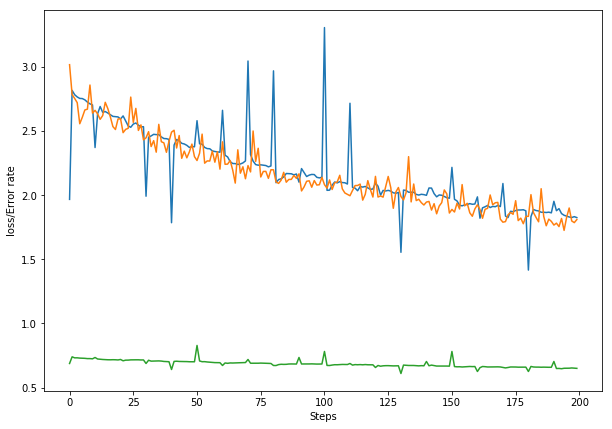

In [34]:
# 在测试集上运行我们的加法机网络，并测试预测准确度
plt.figure(figsize = (10,7))
plt.plot(records)
plt.xlabel('Steps')
plt.ylabel('loss/Error rate')




In [35]:
# 在测试集上运行我们的加法机网络，并测试预测准确度
net.eval()
tests = []

for data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = data
    output = net(Variable(x1), Variable(x2))
    label = y1 + y2
    test = rightness(output.squeeze(),Variable(label))
    tests.append(test)

rights = (sum([tup[0] for tup in tests]), sum([tup[1] for tup in tests]))
right_rate = 1.0*rights[0] / rights[1]
print(right_rate)

0.463
